# Binary phase equilibrium

In [ ]:
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot

When handling two components, we introduce an additional variable to our parameter space: composition. Typically, when visualising the phase space, we would like to visualise it on the temperature, pressure and/or composition axes. However, to do so on a 2D figure will require us to fix one of these variables while varying the other two. In this tutorial, we'll go over how to obtain the varying types of binary phase diagrams using Clapeyron.

Note that this tutorial will focus on 'conventional' binary fluid-phase diagrams (i.e. mixtures of small molecules). Other tutorials will go over other types of systems (such as polymer mixtures, solid-fluid equilibrium and electrolytes).

## Simple binary phase diagrams

As a first step, we'll consider what we refer to as simple binary phase diagrams. Here, we'll vary the composition of the two components but fix either temperature or pressure, also known as *pxy* and *Txy* binary phase diagrams, respectively. Consider a binary mixture of $n$-butane and $n$-hexane:

In [231]:
model = SRK(["butane", "hexane"])

RK{BasicIdeal, SoaveAlpha, NoTranslation, vdW1fRule} with 2 components:
 "butane"
 "hexane"
Contains parameters: a, b, Tc, Pc, Mw

Let us imagine that we have a 50/50 mixture and we want to know its bubble point at $T=$298.15 K (the pressure at which it will just start to boil), as well as the corresponding composition in the gas phase. For this, we can use the `bubble_pressure(model, T, x)` function:

In [236]:
(p, vl, vv, y) = bubble_pressure(model, 298.15, [0.5,0.5])

(129559.90928904162, 0.00012784123527960945, 0.01841671019974433, [0.917483066928342, 0.08251693307165797])

And it is as simple as that! There will also be the corresponding `dew_pressure(model, T, x)` function to obtain the dew point at a given temperature (the pressure at which the mixture just start to condense):


In [237]:
(p, vl, vv, x) = dew_pressure(model, 298.15, y)

(129559.90929012517, 0.00012784123527944974, 0.018416710199566293, [0.5000000000044023, 0.49999999999559774])

As well as the equivalent `bubble_temperature(model, p, x)` and `dew_temperature(model, p, y)` to obtain the bubble/dew points at a given pressure:

In [238]:
(T, vl, vv, y) = bubble_temperature(model, p, x)

(T, vl, vv, x) = dew_temperature(model, p, y)

(298.149999999622, 0.0001278412352791195, 0.018416710199541966, [0.5000000000112885, 0.4999999999887115])

With these four functions, it is now possible to trace the complete phase diagram of $n$-butane and $n$-hexane: First, we'll plot the constant temperature, *pxy* phase diagram:

In [232]:
N    = 201
T    = 298.15

x    = LinRange(0., 1.,  N)
p    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    bub = bubble_pressure(model, T, [x[i], 1-x[i]])
    p[i] = bub[1]
    y[i] = bub[4][1]
end

With the final diagram being:

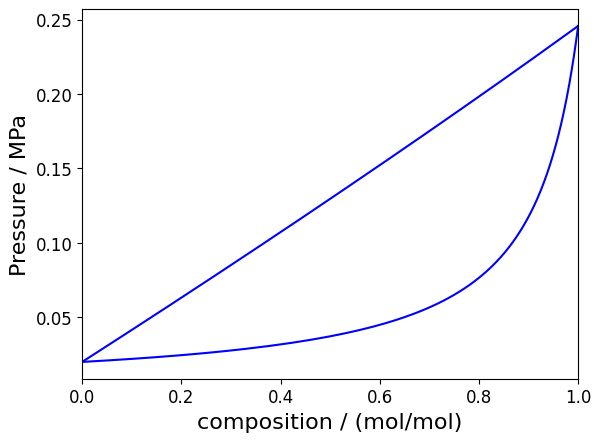

In [233]:
plt.clf()
plt.plot(x, p./1e6, color="blue")
plt.plot(y, p./1e6, color="blue")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("but_hex_pxy.png")
display(plt.gcf())

Very little needs to be changed to obtain the corresponding constant pressure, *Txy* diagram:

In [234]:
N    = 201
p    = 1e5

x    = LinRange(0., 1.,  N)
T    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    bub = bubble_temperature(model, p, [x[i], 1-x[i]])
    T[i] = bub[1]
    y[i] = bub[4][1]
end

With the final diagram being:

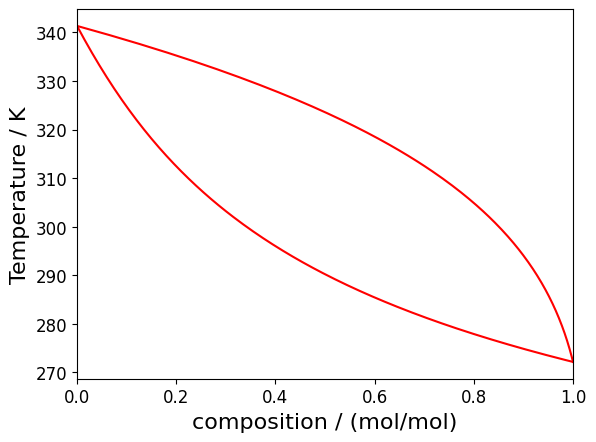

In [235]:
plt.clf()
plt.plot(x, T, color="red")
plt.plot(y, T, color="red")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("but_hex_Txy.pdf")
display(plt.gcf())

Naturally, binary mixtures of linear alkanes are as simple as the diagrams can be (what would normally be referred to as a type-I mixture). In introducing non-idealities, the binary phase diagrams, and how they are drawn, becomes more complicated.


## Azeotropic binary phase diagrams

If we now consider a non-ideal mixture of cyclohexane and methanol:

In [239]:
model = PCSAFT(["cyclohexane", "methanol"])

PCSAFT{BasicIdeal, Float64} with 2 components:
 "cyclohexane"
 "methanol"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol

This mixture will exhibit an azeotrope (a set of conditions where the dew and bubble point occur at the same composition). In this case, one can't just blindly trace the phase diagram. This is primarily because our initial guesses assume that the mixture obeys Raoult's law. As such, these initial guesses won't be suitable for azeotropic mixtures. Much like the pure-component saturation properties, it is best to use the solution of the previous iteration as the initial guess for the next iteration. Consider the constant temperature, *pxy* phase diagram:


In [240]:
N    = 401
idxend = N
T    = 343.15

x    = LinRange(0., 1.,  N)
p    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    if i==1
        bub = bubble_pressure(model, T, [x[i], 1-x[i]])
        p[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(log10.([bub[2],bub[3]]),[x[i+1],1-x[i+1]])
    else
        bub = bubble_pressure(model, T, [x[i], 1-x[i]]; v0 = v0)
        p[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(log10.([bub[2],bub[3]]),bub[4])
        if abs(y[i] - x[i])/x[i] < 1e-3
            idxend = i
            break
        end
    end
end

The corresponding phase diagram is:

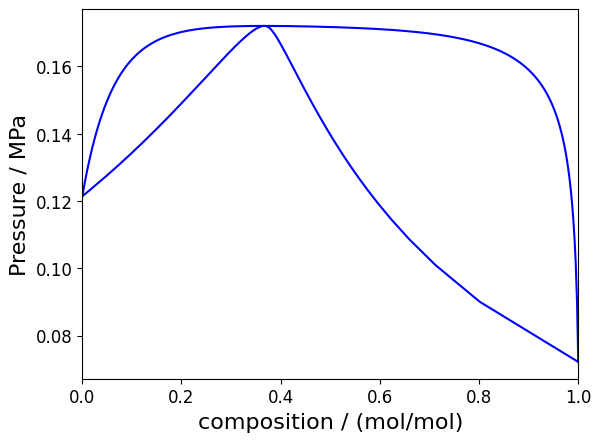

In [241]:
plt.clf()
plt.plot(x, p./1e6, color="blue")
plt.plot(y, p./1e6, color="blue")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("meoh_cyhex_pxy.png")
display(plt.gcf())

Much like the simple case, very little needs to change to handle the corresponding constant pressure, *Txy* phase diagram:


In [242]:
N    = 201
p    = 1e5

x    = LinRange(0., 1.,  N)
T    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    if i==1
        bub = bubble_temperature(model, p, [x[i], 1-x[i]])
        T[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(bub[1],log10.([bub[2],bub[3]]),[x[i+1],1-x[i+1]])
    else
        bub = bubble_temperature(model, p, [x[i], 1-x[i]]; v0 = v0)
        T[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(bub[1],log10.([bub[2],bub[3]]),bub[4])
    end
end

With the corresponding phase diagram being:

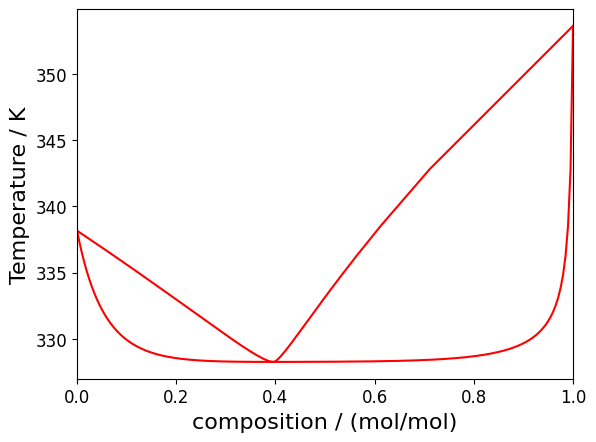

In [243]:
plt.clf()
plt.plot(x, T, color="red")
plt.plot(y, T, color="red")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("meoh_cyhex_Txy.png")
display(plt.gcf())

## Binary phase diagrams with one supercritical component

Consider a mixture of carbon dioxide and $n$-hexane:

In [244]:
model = SRK(["carbon dioxide","hexane"])

RK{BasicIdeal, SoaveAlpha, NoTranslation, vdW1fRule} with 2 components:
 "carbon dioxide"
 "hexane"
Contains parameters: a, b, Tc, Pc, Mw

Thus far, we have only considered conditions where both components are sub-critical (i.e. the phase diagram start and ends at compositions of 0 and 1, respectively). However, when we reach conditions above the critical point of one component, the diagram will end at a critical point rather than at a pure component. It is difficult to predict the exact composition of the critical point ahead of time. As such, one needs to gradually approach the critical point until the dew and bubble curves eventually match (to within a certain tolerance), noting the iteration at which the diagram closed (`idxend`):

In [245]:
N    = 401
idxend = N
T    = 353.15

x    = LinRange(0., 1.,  N)
p    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    if i==1
        bub = bubble_pressure(model, T, [x[i], 1-x[i]])
        p[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(log10.([bub[2],bub[3]]),[x[i+1],1-x[i+1]])
    else
        bub = bubble_pressure(model, T, [x[i], 1-x[i]]; v0 = v0)
        p[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(log10.([bub[2],bub[3]]),bub[4])
        if abs(y[i] - x[i])/x[i] < 1e-3 || isnan(p[i])
            idxend = i-1
            break
        end
    end
end

x = vcat(y[1:idxend],reverse(x[1:idxend]))
p = vcat(p[1:idxend],reverse(p[1:idxend]));

Resulting in the following phase diagram:

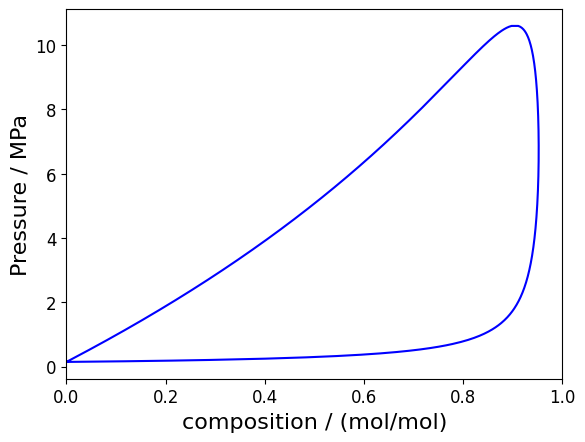

In [246]:
plt.clf()
plt.plot(x, p./1e6, color="blue")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("co2_hex_pxy.png")
display(plt.gcf())

Note that, as you approach the critical point, our solvers will become less stable due to the nature of derivatives near the critical point. You may need a larger number of points than shown above.


### Water+light gases

In some cases, the volatility of the two components is so different, it is not relevant / possible to plot the full phase diagram up to the critical point. This includes systems like water+light gases. In these cases, it is more relevant to plot up to compositions where the predicted pressures are still within a reasonable range. Consider an example of water+carbon dioxide:

In [247]:
model = SAFTVRMie(["carbon dioxide","water"])

SAFTVRMie{BasicIdeal, Float64} with 2 components:
 "carbon dioxide"
 "water"
Contains parameters: Mw, segment, sigma, lambda_a, lambda_r, epsilon, epsilon_assoc, bondvol

For this system, the only interesting composition range is up to 3\% mole fraction of carbon dioxide in the liquid phase:

In [248]:
N    = 401
idxend = N
T    = 333.15

x    = LinRange(0., 0.05,  N)
p    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    if i==1
        bub = bubble_pressure(model, T, [x[i], 1-x[i]])
        p[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(log10.([bub[2],bub[3]]),[x[i+1],1-x[i+1]])
    else
        bub = bubble_pressure(model, T, [x[i], 1-x[i]]; v0 = v0)
        p[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(log10.([bub[2],bub[3]]),bub[4])
    end
end

# x = vcat(y[1:idxend],reverse(x[1:idxend]))
# p = vcat(p[1:idxend],reverse(p[1:idxend]));

InterruptException: InterruptException:

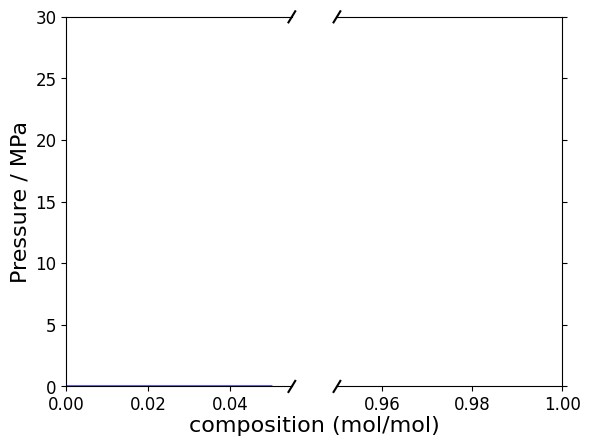

In [249]:
plt.clf()
f,(ax,ax2) = plt.subplots(1,2,sharey=true, facecolor="w")

# plot the same data on both axes
ax.plot(x,p./1e6,color="blue")

ax2.plot(y,p./1e6,color="blue")
ax.set_xlim(0,0.055)
ax.set_ylim(0,30.)
ax2.set_xlim(0.95,1.)
ax2.set_ylim(0,30.)

# hide the spines between ax and ax2
ax.spines["right"].set_visible(false)
ax2.spines["left"].set_visible(false)
ax.yaxis.tick_left()
ax2.yaxis.tick_right()

d = 0.015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
ax.plot((1-d,1+d), (-d,+d), transform=ax.transAxes, color="k", clip_on=false)
ax.plot((1-d,1+d),(1-d,1+d), transform=ax.transAxes, color="k", clip_on=false)

ax2.plot((-d,+d), (1-d,1+d), transform=ax2.transAxes, color="k", clip_on=false)
ax2.plot((-d,+d), (-d,+d), transform=ax2.transAxes, color="k", clip_on=false)

ax.set_xlabel("composition (mol/mol)",fontsize=16)
ax.xaxis.set_label_coords(1.1, -0.08)
ax.set_ylabel("Pressure / MPa",fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax2.get_xticklabels(), fontsize=12)

plt.setp(ax.get_yticklabels(), fontsize=12)
# plt.savefig("co2_h2o_pxy.png")
display(plt.gcf())

Going much beyond this composition range, particularly when one reaches pressures in GPa, will typically encounter numerical issues. As such, when modelling in these conditions, it is better to use methods that are more-numerically stable (such as the `FugBubblePressure` methods).

## Binary phase diagrams with LLE

Thus far, we have only considered vapour–liquid equilibrium. However, in some mixtures, one can also obtain liquid–liquid equilibrium (LLE). As an example of this, the *Txy* diagram for the methanol+cyclohexane mixture considered earlier will exhibit LLE at slightly lower temperatures. To obtain the composition of each phase, one needs to perform a flash calculation at constant temperature and pressure, remembering to specify that we are search for LLE:

In [250]:
model = PCSAFT(["cyclohexane", "methanol"])

PCSAFT{BasicIdeal, Float64} with 2 components:
 "cyclohexane"
 "methanol"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol

In [251]:
(n,ϕ,G) = tp_flash(model,1e5,288.15,[0.5,0.5],MichelsenTPFlash(equilibrium=:lle));

A few things to note:
1. In the above, we set the system composition to 50/50. However, there is no guarantee the phase split will occur exactly there (especially in size asymmetric systems). One easy way to check if a phase split occurs is to use the `Clapeyron.isstable(model, p, T, z)` function. If this function returns `false`, then we know the system is unstable as a single phase and must phase split:

In [252]:
Clapeyron.isstable(model, 1e5, 298.15, [0.5,0.5])

false

2. Although we have a more-detailed tutorial going over flash algorithms, one way to quickly speed up the calculations is to specify an initial guess for the partition coefficient of each species. So long as the magnitude of each coefficient is large enough, the flash algorithm should work:

In [253]:
tp_flash(model,1e5,288.15,[0.5,0.5],MichelsenTPFlash(equilibrium=:lle,K0=[1e5,1e-4]));

We can first trace the VLE region as we did previously:

In [254]:
N    = 201
p    = 1e5

x    = LinRange(0., 1.,  N)
T    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    if i==1
        bub = bubble_temperature(model, p, [x[i], 1-x[i]])
        T[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(bub[1],log10.([bub[2],bub[3]]),[x[i+1],1-x[i+1]])
    else
        bub = bubble_temperature(model, p, [x[i], 1-x[i]]; v0 = v0)
        T[i] = bub[1]
        y[i] = bub[4][1]
        v0   = vcat(bub[1],log10.([bub[2],bub[3]]),bub[4])
    end
end

To trace the full LLE region, we simply need to iterate in temperature (or pressure) until the LLE region closes at the UCST (or LCST). Much like the earlier system with one supercritical component, we don't necessarily know ahead of time where the region closes. As such, we need to verify the difference in composition between each phase. Further, unless the critical point is at exactly 50/50, we will typically need to modify the value of the system composition to ensure it lies perfectly in the middle of the phase diagram. Below we show a complete example to trace the LLE region:

In [255]:
N    = 200
Tlle = LinRange(300.,minimum(T),N)
x1   = zeros(N)
x2   = zeros(N)

K0 = [1e5, 1e-4]
z  = [0.5,0.5]

idxend = N
for i in 1:N
    (n,_,_) = tp_flash(model, p, Tlle[i], z, MichelsenTPFlash(equilibrium=:lle, K0=K0))
    K0 = n[2,:]./n[1,:]
    z = (n[1,:]+n[2,:])/2
    x1[i] = n[1,1]
    x2[i] = n[2,1]
    if abs(x1[i]-x2[i])<1e-3
        idxend = i
        break
    end
end

The resulting phase diagram then looks like:

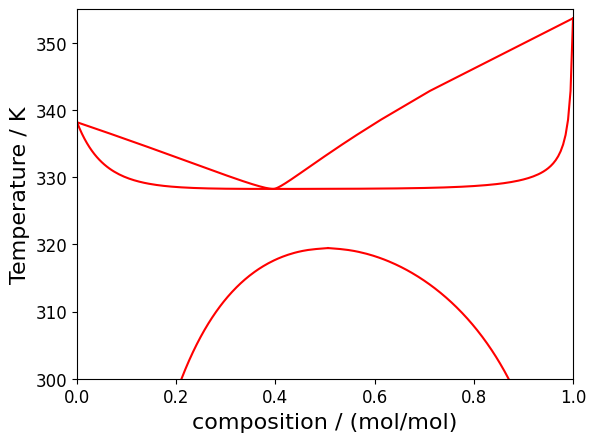

In [256]:
plt.clf()
plt.plot(x, T, color="red")
plt.plot(y, T, color="red")

plt.plot(x1[1:idxend], Tlle[1:idxend], color="red")
plt.plot(x2[1:idxend], Tlle[1:idxend], color="red")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.ylim([300,355])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("meoh_cyhex_Txy_lle.png")
display(plt.gcf())

## Binary phase diagram with VLLE

In some mixtures, it is also possible for the VLE and LLE mixtures to meet and form vapour–liquid–liquid equilibrium (VLLE). While this might sound more challenging to detect than LLE, there are actually ways to identify VLLE from a VLE curve. For this example, we'll consider 1-pentanol+water, using a combining rule to obtain the cross-association:

In [260]:
model = PCSAFT(["1-pentanol", "water"]; assoc_options=AssocOptions(combining=:elliott))

PCSAFT{BasicIdeal, Float64} with 2 components:
 "1-pentanol"
 "water"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol

Once VLLE has been identified, to solve for its exact state, we can use the `VLLE_pressure(model, T)` / `VLLE_temperature(model, p)` functions. Unfortunately, generating good initial guesses automatically is very challenging. As such, users will need to provide decent initial guesses. With the diagram above, we can tell that VLLE will be located right where the dew curve crosses itself, allowing us to identify the composition of the three phases. The initial guesses for the volume can then be obtained just using the `volume` function at the pressure, temperature and composition identified. Remembering to provide the `log10` of the volume, we can obtain the VLLE point:


In [264]:
T    = 343.15

(p3, vl, vll, vv, x3, xx3, y3) = VLLE_pressure(model, 
T; v0 = [-4.7,-4.05,-0.1,0.001,0.7,0.15])

(35079.35262054428, 2.0290656645856746e-5, 7.440520356867208e-5, 0.08041940115039242, [0.002020801796989742, 0.9979791982030103], [0.5829926745745662, 0.41700732542543384], [0.11016762215802567, 0.8898323778419743])

With this point identified, we can obtain the VLE and LLE regions just as we did previously "(one can imagine something very similar for the isobaric phase diagram):

In [265]:
N    = 201

x1    = LinRange(0., x3[1],  N)
p1    = zeros(N)
y1    = zeros(N)

x2    = LinRange(1., xx3[1],  N)
p2    = zeros(N)
y2    = zeros(N)

v01 = nothing
v02 = nothing
for i in 1:N
    if i==1
        bub = bubble_pressure(model, T, [x1[i], 1-x1[i]])
        p1[i] = bub[1]
        y1[i] = bub[4][1]
        v01   = vcat(log10.([bub[2],bub[3]]),[x1[i+1],1-x1[i+1]])

        bub = bubble_pressure(model, T, [x2[i], 1-x2[i]])
        p2[i] = bub[1]
        y2[i] = bub[4][1]
        v02   = vcat(log10.([bub[2],bub[3]]),[x2[i+1],1-x2[i+1]])
    else
        bub = bubble_pressure(model, T, [x1[i], 1-x1[i]]; v0 = v01)
        p1[i] = bub[1]
        y1[i] = bub[4][1]
        v01   = vcat(log10.([bub[2],bub[3]]),bub[4])

        bub = bubble_pressure(model, T, [x2[i], 1-x2[i]]; v0 = v02)
        p2[i] = bub[1]
        y2[i] = bub[4][1]
        v02   = vcat(log10.([bub[2],bub[3]]),bub[4])
    end
end

In [266]:
N    = 200
plle = LinRange(p3, 2*p3, N)
xx1   = zeros(N)
xx2   = zeros(N)

K0 = x3 ./ xx3
z  = (x3 .+ xx3)./2

idxend = N
for i in 1:N
    (n,_,_) = tp_flash(model, plle[i], T, z, MichelsenTPFlash(equilibrium=:lle, K0=K0))
    K0 = n[2,:]./n[1,:]
    z = (n[1,:]+n[2,:])/2
    xx1[i] = n[1,1]
    xx2[i] = n[2,1]
    if abs(x1[i]-x2[i])<1e-3
        idxend = i
        break
    end
end

* Isothermal phase diagram:

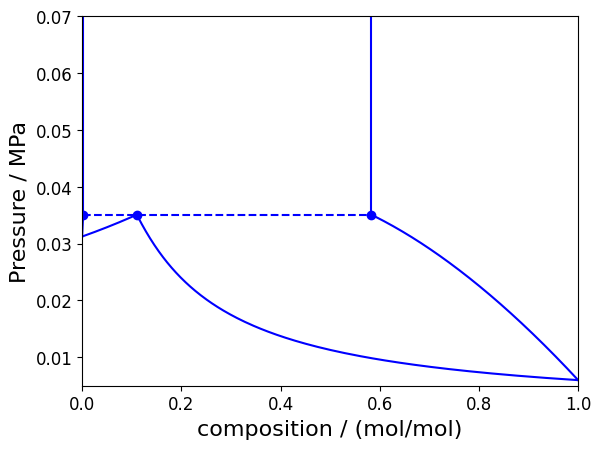

In [267]:
plt.clf()
plt.plot(x1, p1./1e6, color="blue")
plt.plot(x2, p2./1e6, color="blue")
plt.plot(y1, p1./1e6, color="blue")
plt.plot(y2, p2./1e6, color="blue")
plt.plot([x3[1],y3[1],xx3[1]],[p3,p3,p3]./1e6, color="blue", linestyle="--", marker="o")
plt.plot(xx1, plle./1e6, color="blue")
plt.plot(xx2, plle./1e6, color="blue")

plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlim([0,1])
plt.ylim([0.005,0.07])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("water_pentoh_pxy.png")
display(plt.gcf())

For the isobaric phase diagram:

In [268]:
p    = 1e5

(T3, vl, vll, vv, x3, xx3, y3) = VLLE_temperature(model, 
p; v0 = [365.,-4.7,-4.05,-0.1,0.001,0.7,0.15])

(369.1405222962388, 2.0780264094009713e-5, 7.083157011667342e-5, 0.030089684647176873, [0.003486889243408434, 0.9965131107565915], [0.5243712730530754, 0.4756287269469246], [0.12776736574050074, 0.8722326342594993])

In [269]:
N    = 201

x1    = LinRange(0., x3[1],  N)
T1    = zeros(N)
y1    = zeros(N)

x2    = LinRange(1., xx3[1],  N)
T2    = zeros(N)
y2    = zeros(N)

v01 = nothing
v02 = nothing
for i in 1:N
    if i==1
        bub = bubble_temperature(model, p, [x1[i], 1-x1[i]])
        T1[i] = bub[1]
        y1[i] = bub[4][1]
        v01   = vcat(bub[1],log10.([bub[2],bub[3]]),[x1[i+1],1-x1[i+1]])

        bub = bubble_temperature(model, p, [x2[i], 1-x2[i]])
        T2[i] = bub[1]
        y2[i] = bub[4][1]
        v02   = vcat(bub[1],log10.([bub[2],bub[3]]),[x2[i+1],1-x2[i+1]])
    else
        bub = bubble_temperature(model, p, [x1[i], 1-x1[i]]; v0 = v01)
        T1[i] = bub[1]
        y1[i] = bub[4][1]
        v01   = vcat(bub[1],log10.([bub[2],bub[3]]),bub[4])

        bub = bubble_temperature(model, p, [x2[i], 1-x2[i]]; v0 = v02)
        T2[i] = bub[1]
        y2[i] = bub[4][1]
        v02   = vcat(bub[1],log10.([bub[2],bub[3]]),bub[4])
    end
end

In [270]:
N    = 200
Tlle = LinRange(T3, T3-30., N)
xx1   = zeros(N)
xx2   = zeros(N)

K0 = x3 ./ xx3
z  = (x3 .+ xx3)./2

idxend = N
for i in 1:N
    (n,_,_) = tp_flash(model, p, Tlle[i], z, MichelsenTPFlash(equilibrium=:lle, K0=K0))
    K0 = n[2,:]./n[1,:]
    z = (n[1,:]+n[2,:])/2
    xx1[i] = n[1,1]
    xx2[i] = n[2,1]
    if abs(x1[i]-x2[i])<1e-3
        idxend = i
        break
    end
end

Giving the resulting plot:

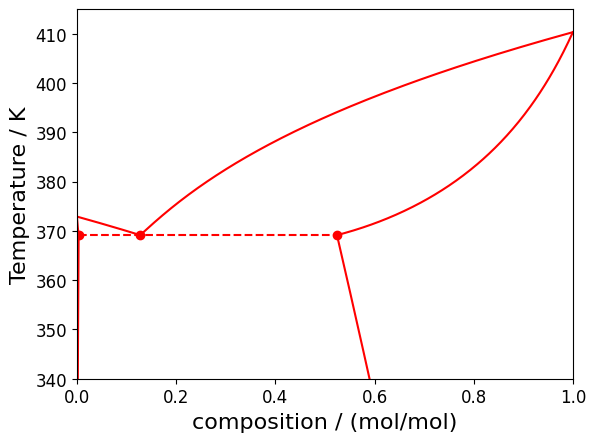

In [271]:
plt.clf()
plt.plot(x1, T1, color="red")
plt.plot(x2, T2, color="red")

plt.plot(y1, T1, color="red")
plt.plot(y2, T2, color="red")

plt.plot([x3[1],y3[1],xx3[1]],[T3,T3,T3], color="red", linestyle="--", marker="o")

plt.plot(xx1, Tlle, color="red")
plt.plot(xx2, Tlle, color="red")

plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.ylim([340,415])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("water_pentoh_Txy.png")
display(plt.gcf())

This covers most binary phase diagrams one might be interested in when holding either temperature or pressure fixed.


## *pT* isopleths

The next class of phase diagram we'll consider is when we project the diagram onto the pressure and temperature axis, holding composition constant (known at *pT* isopleths). These diagrams can be applied to any number of components but, for the time being, we'll only consider a binary mixture. For these particular diagrams, it is recommended that users familiarise themselves with the concept of critical points of mixtures, cricondentherms and cricondenbars. These diagrams can become quite complex and, in this tutorial, we'll only go over how to obtain the simplest form for *pT* isopleths (for type-I mixtures) using an ethane+decane mixture:


In [275]:
model = PR(["ethane","decane"])

PR{BasicIdeal, PRAlpha, NoTranslation, vdW1fRule} with 2 components:
 "ethane"
 "decane"
Contains parameters: a, b, Tc, Pc, Mw

As a starting point, similar the saturation curve of a pure component, we'll obtain the critical point of the mixture using `crit_mix(model, z)`:


In [281]:
z = [0.95,0.05]

(Tc, pc, vc) = crit_mix(model,z)

(352.7590586411515, 8.711875761029465e6, 0.00012655401697374196)

To trace the *pT* isopleth, we need to obtain the bubble and dew curves up to this critical point. However, there will be a few caveats. We'll use almost the same code as we used in all other phase diagrams:


In [282]:
N = 300
T1, T2 = LinRange(220., Tc, N), LinRange(220., Tc, N)
p1, p2 = zeros(N), zeros(N)
v01 = nothing
v02 = nothing

for i in 1:N
    if i == 1
        bub = bubble_pressure(model, T1[i], z)
        p1[i] = bub[1]
        v01   = vcat(log10.([bub[2],bub[3]]),bub[4])
        
        bub = dew_pressure(model, T2[i], z)
        p2[i] = bub[1]
        v02   = vcat(log10.([bub[2],bub[3]]),bub[4])
    else
        bub = bubble_pressure(model, T1[i], z; v0 = v01)
        p1[i] = bub[1]
        v01   = vcat(log10.([bub[2],bub[3]]),bub[4])
        
        bub = dew_pressure(model, T2[i], z; v0 = v02)
        p2[i] = bub[1]
        v02   = vcat(log10.([bub[2],bub[3]]),bub[4])
    end
end

However, if we plot these two curves, we can see that the diagram isn't complete. In this case, the cricondentherm and cricondenbar are both above the critical point of the mixture. To close the *pT* isopleths, we need to add 1-2 more sections to the plot.

Tracing the dew point from the end of `p2` to `pc` (using `dew_temperature`):

In [283]:
p3 = LinRange(p2[end], pc, N)
T3 = zeros(N)

v03 = append!([Tc],v02)

for i in 1:N
    dew = dew_temperature(model, p3[i], z; v0 = v03)
    T3[i] = dew[1]
    v03   = vcat(dew[1],log10.([dew[2],dew[3]]),dew[4])
end


Tracing the dew point from the end of `T2` to `Tc` (using `dew_pressure`). This part may not be needed for all *pT* isopleths if the cricondenbar is below `Tc`:

In [284]:
if abs(Tc - T3[end]) < 1e-3
    T4 = []
    p4 = []
else
    T4 = LinRange(T3[end], Tc, N)
    p4 = zeros(N)

    v04 = v03[2:end]

    for i in 1:N
        dew = dew_pressure(model, T4[i], z; v0 = v04)
        p4[i] = dew[1]
        v04 = vcat(log10.([dew[2],dew[3]]),dew[4])
    end
end

And with that, we can trace the full *pT* isopleth:


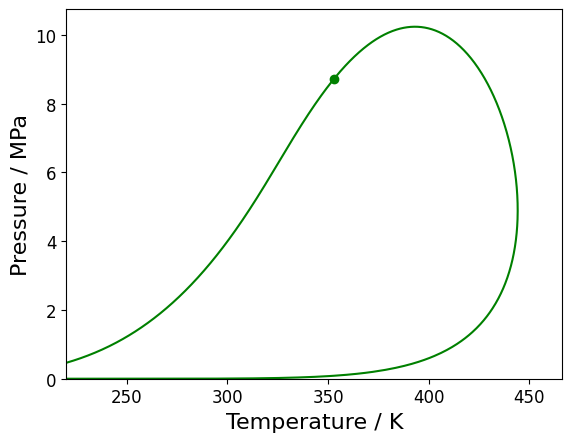

In [285]:
T = vcat(T2, T3, T4, T1)
p = vcat(p2, p3, p4, p1)

plt.clf()
plt.plot(T, p./1e6, color="green")

plt.plot([Tc], [pc]./1e6, color="green", marker="o")

plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlabel("Temperature / K",fontsize=16)
plt.xlim([220,maximum(T)*1.05])
plt.ylim([0,maximum(p[.!(isnan.(p))])*1.05/1e6])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("eth_dec_pT.png")
display(plt.gcf())

This approach is generalised for any number of components. Where it will begin to fail is more-complex phase diagrams beyond type-I, where LLE and VLLE regions begin to appear. These will typically be at low temperature and high pressures. It is possible to trace these types of diagrams using Clapeyron; however, it will involve a lot more manual specification of initial guesses and is very difficult to do so without knowing ahead of time where these regions occur.


## *pT* Projection

Thus far, all the phase diagrams we've considered have been slices of the global binary phase diagram. This is convenient when we want to obtain the exact conditions at which phase equilibrium will occur. However, if we want to get a better idea of the global phase behaviour of the mixture, it is possible to project the global phase diagram onto a pressure-temperature plot. Here, we are only concerned with tracing the region in which the mixture _could_ experience phase equilibrium.

Note that, at this stage, there is no automatic way to determine whether a mixture is a certain type ahead of time. Thus, to make these figures, you must know that the mixture is a particular type.

### Type-I mixture

Initially, we will continue to consider the ethane+decane binary mixture. The first curves we need to draw are the saturation curves of the pure components (which we know how to obtain from an earlier tutorial):


In [286]:
model = PR(["ethane","decane"])

PR{BasicIdeal, PRAlpha, NoTranslation, vdW1fRule} with 2 components:
 "ethane"
 "decane"
Contains parameters: a, b, Tc, Pc, Mw

In [287]:
N = 1000

pures = split_model(model)
crit = crit_pure.(pures)

Tc1, pc1, _ = crit[1]
Tc2, pc2, _ = crit[2]

T1 = LinRange(140, Tc1, N)
T2 = LinRange(250, Tc2, N)

p1 = zeros(N)
p2 = zeros(N)

v01 = nothing
v02 = nothing

for i in 1:N
    if i ==1 
        sat = saturation_pressure(pures[1], T1[i])
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i])
        p2[i] = sat[1]
        v02 = sat[2:3]
    else
        sat = saturation_pressure(pures[1], T1[i]; v0 = v01)
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i]; v0 = v02)
        p2[i] = sat[1]
        v02 = sat[2:3]
    end

end

To connect both curves of this mixture, we need to include the critical curve. To do this, as introduced earlier, we have the `crit_mix(model, z)` function:


In [288]:
x = LinRange(0., 1., N)
T3, p3 = zeros(N), zeros(N)

v0 = nothing
for i in 1:N
    if i == 1
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]])
    else
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]]; v0 = v0)
    end
    v0 = [log10(vc), T3[i]]
end

For simple mixtures, one doesn't need to update the initial guesses. And with that, we have now drawn the *pT* projection for this mixture:


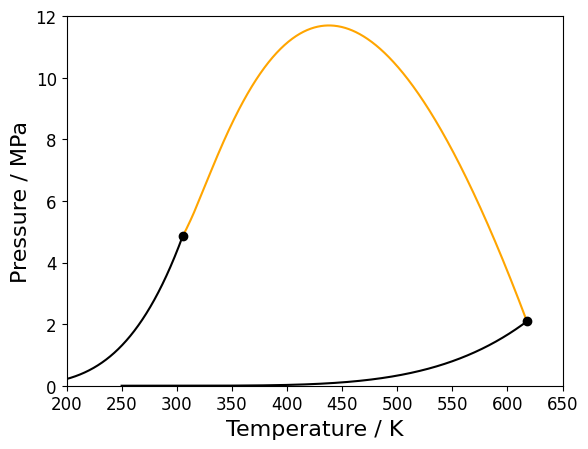

In [289]:
plt.clf()
plt.plot(T1, p1./1e6, color = "black")
plt.plot(T2, p2./1e6, color = "black")
plt.plot(T3, p3./1e6, color = "orange")
plt.plot([Tc1, Tc2], [pc1, pc2]./1e6, color="black", marker="o", linestyle="")
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlabel("Temperature / K",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 12])
plt.xlim([200, 650])
# plt.savefig("eth_dec_pT_mix.png")
display(plt.gcf())

Unfortunately, this is the simplest type of *pT* projection one can draw. 


### Type-II Mixture

For the type-II mixture, we'll consider cyclohexane and methanol using PC-SAFT:


In [290]:
model = PCSAFT(["cyclohexane","methanol"])

PCSAFT{BasicIdeal, Float64} with 2 components:
 "cyclohexane"
 "methanol"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol

In [291]:
N = 1000

pures = split_model(model)
crit = crit_pure.(pures)

Tc1, pc1, _ = crit[1]
Tc2, pc2, _ = crit[2]

T1 = LinRange(295, Tc1, N)
T2 = LinRange(295, Tc2, N)

p1 = zeros(N)
p2 = zeros(N)

v01 = nothing
v02 = nothing

for i in 1:N
    if i ==1 
        sat = saturation_pressure(pures[1], T1[i])
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i])
        p2[i] = sat[1]
        v02 = sat[2:3]
    else
        sat = saturation_pressure(pures[1], T1[i]; v0 = v01)
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i]; v0 = v02)
        p2[i] = sat[1]
        v02 = sat[2:3]
    end

end

We can obtain the saturation and critical curves of this system using the same approach as the type-I system, although it may now be a good idea to re-use initial guesses:


In [292]:
x = LinRange(0., 1., N)
T3, p3 = zeros(N), zeros(N)

v0 = nothing
for i in 1:N
    if i == 1
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]])
    else
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]]; v0 = v0)
    end
    v0 = [log10(vc), T3[i]]
end

The critical curve may look a bit odd but it is physical (as a challenge, try to draw the *pxy* phase diagram around 500K). What makes type-II mixtures unique is the fact that these system exhibit VLLE behaviour, typically at low temperatures. Due to the Gibbs Phase Rule, there is only a single pressure at a given temperature that VLLE occurs. As such, we can trace the VLLE region using a curve. Similarly, an LLE region will also be present which terminates at an upper-critical solution temperature (UCST). The VLLE and UCST curve eventually meet at what is referred to as the upper-critical end point (UCEP) which is where a critical 'liquid' phase is in equilibrium with a vapour phase. As it acts as the end point, it is convenient to obtain the UCEP first before tracing the VLLE and UCST curves. This can be done using the `UCEP_mix(model)` function. Note that this function is highly sensitive to initial guesses and is not very generalised:


In [293]:
(T_ucep, p_ucep, vl_ucep, vv_ucep, x_ucep, y_ucep) = UCEP_mix(model)

(319.3687745644058, 70531.68542902727, 7.883409544453343e-5, 0.03532019955594591, [0.5054291106816069, 0.4945708893183931], [0.4121361614832652, 0.5878638385167347])

With this point obtained, we can trace the VLLE curve:


In [294]:
T4 = LinRange(295., T_ucep, N)
p4 = zeros(N)

vl = volume(model,70531.,T4[1],[0.99,0.01]; phase=:l)
vll = volume(model,70531.,T4[1],[0.01,0.99]; phase=:l)
vv = volume(model,70531.,T4[1],[0.5,0.5]; phase = :v)

v0 = [log10(vl), log10(vll), log10(vv), 0.99, 0.01, 0.5]

for i in 1:N
    p4[i], vl, vll, vv, x, xx, y = VLLE_pressure(model,T4[i]; v0 = v0)
    v0 = [log10(vl), log10(vll), log10(vv), x[1], xx[1], y[1]]
end

And the UCST curve (using `UCST_mix(model, T)`):


In [295]:
T5 = LinRange(T_ucep, 330, N)
p5 = zeros(N)

v0 = [log10(vl_ucep), x_ucep]
for i in 1:N
    p5[i], vc, x_c = UCST_mix(model, T5[i]; v0 = v0)
    v0 = [log10(vc), x_c]
end

InterruptException: InterruptException:

While these represent all the characteristic curves of interest for this mixture, as this mixture exhibits azeotropic behaviour starting from the UCEP and meeting the critical curve, it is possible to also trace this curve using `azeotrope_pressure(model,T)`:


In [296]:
T6 = LinRange(T_ucep, minimum(T3), N)
p6 = zeros(N)

v0 = y_ucep
for i in 1:N
    p6[i], vla, vva, x_a = azeotrope_pressure(model, T6[i]; v0 = v0)
    v0 = x_a
end

And with this, we can complete the phase diagram:

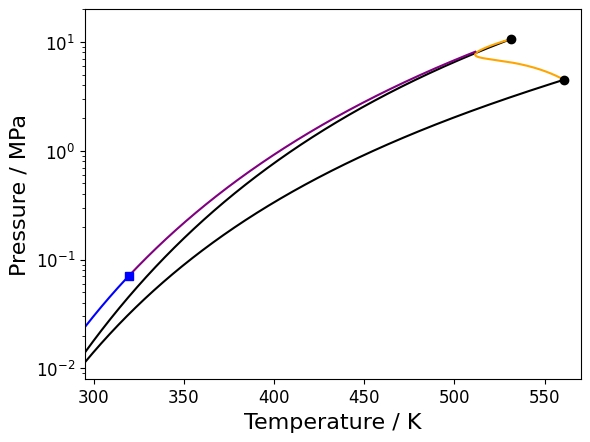

In [297]:
plt.clf()
plt.semilogy(T1, p1./1e6, color = "black")
plt.plot(T2, p2./1e6, color = "black")
plt.plot(T3, p3./1e6, color = "orange")
plt.plot(T4, p4./1e6, color = "blue")
plt.plot(T5, p5./1e6, color = "green")
plt.plot(T6, p6./1e6, color = "purple")

plt.plot([Tc1, Tc2], [pc1, pc2]./1e6, color="black", marker="o", linestyle="")
plt.plot([T_ucep], [p_ucep]./1e6, color="blue", marker="s", linestyle="")

plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlabel("Temperature / K",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 20])
plt.xlim([295, 570])
# plt.savefig("cyhex_meoh_pT_full.png")
display(plt.gcf())

Note that there is no formal definition for where the azeotrope meets the critical curve. Thus the end point must be determined ahead of time.


### Type III mixture

The type-III mixture we will be considering is methane+heptane using GERG-2008:


In [299]:
model = GERG2008(["heptane","methane"])

MultiFluid{EmpiricAncillary, AsymmetricMixing, EmpiricDeparture} with 2 components:
 "heptane"
 "methane"
Contains parameters: Mw, Tc, Pc, Vc, Tr, Vr, acentricfactor, lb_volume, reference_state

Type-III mixtures are unique as the critical curve is broken into two. If one starts from the less volatile component, we find that the curve does not reconnect with the critical point of the more volatile component:

In [300]:
N = 200

pures = split_model(model)
crit = crit_pure.(pures)

Tc1, pc1, _ = crit[1]
Tc2, pc2, _ = crit[2]

T1 = LinRange(200, Tc1, N)
T2 = LinRange(150, Tc2, N)

p1 = zeros(N)
p2 = zeros(N)

v01 = nothing
v02 = nothing

for i in 1:N
    if i ==1 
        sat = saturation_pressure(pures[1], T1[i])
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i])
        p2[i] = sat[1]
        v02 = sat[2:3]
    else
        sat = saturation_pressure(pures[1], T1[i]; v0 = v01)
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i]; v0 = v02)
        p2[i] = sat[1]
        v02 = sat[2:3]
    end

end

In [192]:
x = LinRange(1., 0.2, N)
T3, p3 = zeros(N), zeros(N)

v0 = nothing
for i in 1:N
    if i == 1
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]])
    else
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]]; v0 = v0)
    end
    v0 = [log10(vc), T3[i]]
end

Eventually, this curve becomes the UCST curve. However, there is a critical curve originating from the more volatile component. However, this time, it terminates at the UCEP. We can repeat the same steps as above to obtain the UCEP:

In [ ]:
T = 193.
p = 4.8e6
y = [0.008,0.992]
vv = volume(model, p, T, y; phase=:v)
x = [0.7,0.3]
vl = volume(model, p, T, x; phase=:l)

v0 = [y[1], x[1], log10(vv), log10(vl), T]

(T_ucep, p_ucep, vl_ucep, vv_ucep, x_ucep, y_ucep) = UCEP_mix(model; v0 = v0)

In [194]:
x = LinRange(0.0, x_ucep[1], Int(N/10))
T4, p4 = zeros(Int(N/10)), zeros(Int(N/10))

v0 = nothing
for i in 1:Int(N/10)
    if i == 1
        (T4[i], p4[i], vc) = crit_mix(model, [x[i], 1-x[i]])
    else
        (T4[i], p4[i], vc) = crit_mix(model, [x[i], 1-x[i]]; v0 = v0)
    end
    v0 = [log10(vc), T4[i]]
end

In [195]:
T5 = LinRange(150, T_ucep, N)
p5 = zeros(N)

vv = volume(model,1e6,T5[1],[0.02,0.98]; phase = :v)
vll = volume(model,1e6,T5[1],[0.0001,0.9999]; phase=:l)
vl = volume(model,1e6,T5[1],[0.9,0.1]; phase = :l)

v0 = [log10(vl), log10(vll), log10(vv), 0.9, 0.0001, 0.02]

for i in 1:N
    p5[i], vl, vll, vv, x, xx, y = VLLE_pressure(model,T5[i]; v0 = v0)
    v0 = [log10(vl), log10(vll), log10(vv), x[1], xx[1], y[1]]
end

Especially in cases with very different volatilities, it will be very difficult to see the separation between the VLLE, critical and saturation curve as shown above. However, if one zooms in, we can see the three independent curves.

In [ ]:
plt.clf()
plt.plot(T1, p1./1e6, color = "black")
plt.plot(T2, p2./1e6, color = "black")
plt.plot(T3, p3./1e6, color = "orange")
plt.plot(T4, p4./1e6, color = "orange")
plt.plot(T5, p5./1e6, color = "blue")

plt.plot([Tc1, Tc2], [pc1, pc2]./1e6, color="black", marker="o", linestyle="")
plt.plot([T_ucep], [p_ucep]./1e6, color="blue", marker="s", linestyle="")

plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlabel("Temperature / K",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([4, 5.5])
plt.xlim([185, 197])
plt.savefig("me_hept_pT_zoom.png")
display(plt.gcf()) 

### Type-V mixture

The final class of binary mixture we'll consider is type-IV/V. In these mixtures, we have more than one UCEP. Once again, the critical curve is  broken up into two. However, this time, both of them reconnect on a UCEP. The only difference between type-IV and type-V is that the former has an additional UCEP due to the presence of a UCST curve. As we have already shown how to trace this curve in type-II mixtures, we'll focus on type-V mixtures. In this case, we'll be looking at a mixture of methane and hexane:


In [ ]:
model = PR(["hexane","methane"])

In [90]:
N = 2000

pures = split_model(model)
crit = crit_pure.(pures)

Tc1, pc1, _ = crit[1]
Tc2, pc2, _ = crit[2]

T1 = LinRange(250, Tc1, N)
T2 = LinRange(170, Tc2, N)

p1 = zeros(N)
p2 = zeros(N)

v01 = nothing
v02 = nothing

for i in 1:N
    if i ==1 
        sat = saturation_pressure(pures[1], T1[i])
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i])
        p2[i] = sat[1]
        v02 = sat[2:3]
    else
        sat = saturation_pressure(pures[1], T1[i]; v0 = v01)
        p1[i] = sat[1]
        v01 = sat[2:3]

        sat = saturation_pressure(pures[2], T2[i]; v0 = v02)
        p2[i] = sat[1]
        v02 = sat[2:3]
    end

end

Examining the critical curve originating from the less-volatile component, the critical curve overshoots the critical point of the more volatile component. This critical curve will terminate at the first UCEP. The critical curve originating from the more volatile component will terminate at a second UCEP. Connecting the two UCEPs will be the VLLE curve. We have described all the tools needed to trace these curves in earlier section.

In [ ]:
T = 195.2
p = 3.e6
y = [1e-5,1-1e-5]
vv = volume(model, p, T, y; phase=:v)
x = [0.1,0.9]
vl = volume(model, p, T, x; phase=:l)

v0 = [y[1], x[1], log10(vv), log10(vl), T]

(T_ucep1, p_ucep1, vl_ucep, vv_ucep, x_ucep1, y_ucep1) = UCEP_mix(model; v0 = v0)

In [ ]:
T = 176.0
p = 2.6e6
y = [5e-6,1-5e-6]
vv = volume(model, p, T, y; phase=:v)
x = [0.07,0.93]
vl = volume(model, p, T, x; phase=:l)

v0 = [x[1], y[1], log10(vl), log10(vv), T]

(T_ucep2, p_ucep2, vl_ucep, vv_ucep, x_ucep2, y_ucep2) = UCEP_mix(model; v0 = v0)

In [ ]:
x = LinRange(1., x_ucep2[1], N)
T3, p3 = zeros(N), zeros(N)

v0 = nothing
for i in 1:N
    if i == 1
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]])
    else
        (T3[i], p3[i], vc) = crit_mix(model, [x[i], 1-x[i]]; v0 = v0)
    end
    v0 = [log10(vc), T3[i]]
end

In [219]:
x = LinRange(0.0, x_ucep1[1], Int(N/100))
T4, p4 = zeros(Int(N/100)), zeros(Int(N/100))

v0 = nothing
for i in 1:Int(N/100)
    println(i)
    if i == 1
        (T4[i], p4[i], vc) = crit_mix(model, [x[i], 1-x[i]])
    else
        (T4[i], p4[i], vc) = crit_mix(model, [x[i], 1-x[i]]; v0 = v0)
    end
    v0 = [log10(vc), T4[i]]
end

In [ ]:
T5 = LinRange(190, T_ucep1, N)
p5 = zeros(N)
y = [1e-5,1-1e-5]
x = [0.8,0.1]
xx = [0.05,0.95]
vv = volume(model,1e6,T5[1],y; phase = :v)
vll = volume(model,1e6,T5[1],xx; phase=:l)
vl = volume(model,1e6,T5[1],x; phase = :l)

v0 = [log10(vl), log10(vll), log10(vv),x[1], xx[1], y[1]]

for i in 1:N
    p5[i], vl, vll, vv, x, xx, y = VLLE_pressure(model,T5[i]; v0 = v0)
    v0 = [log10(vl), log10(vll), log10(vv), x[1], xx[1], y[1]]
    println(x[1], " ", xx[1]," ", y[1])
end

In [184]:
T6 = LinRange(190, T_ucep2, N)
p6 = zeros(N)
y = [1e-5,1-1e-5]
x = [0.8,0.1]
xx = [0.05,0.95]
vv = volume(model,1e6,T6[1],y; phase = :v)
vll = volume(model,1e6,T6[1],xx; phase=:l)
vl = volume(model,1e6,T6[1],x; phase = :l)

v0 = [log10(vl), log10(vll), log10(vv),x[1], xx[1], y[1]]

for i in 1:N
    p6[i], vl, vll, vv, x, xx, y = VLLE_pressure(model,T6[i]; v0 = v0)
    v0 = [log10(vl), log10(vll), log10(vv), x[1], xx[1], y[1]]
    println(x[1], " ", xx[1]," ", y[1])
end

Zooming in to the UCEPs, we see that, much like the previous example, the VLLE curve is very close to the saturation curve of the less-volatile component:

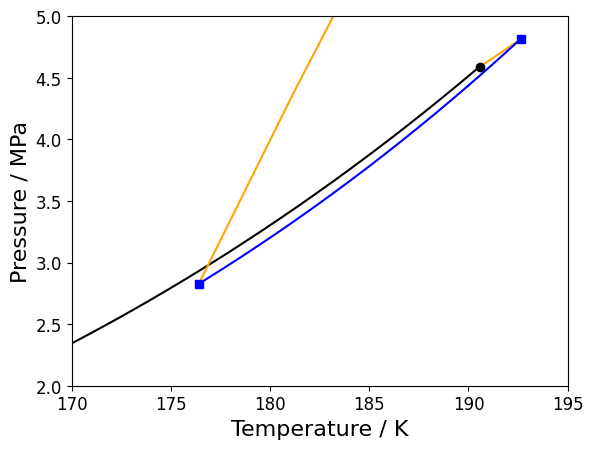

In [230]:
plt.clf()
plt.plot(T1, p1./1e6, color = "black")
plt.plot(T2, p2./1e6, color = "black")
plt.plot(T3, p3./1e6, color = "orange")
plt.plot(T4, p4./1e6, color = "orange")
plt.plot(T5, p5./1e6, color = "blue")
plt.plot(T6, p6./1e6, color = "blue")

plt.plot([Tc1, Tc2], [pc1, pc2]./1e6, color="black", marker="o", linestyle="")
plt.plot([T_ucep1], [p_ucep1]./1e6, color="blue", marker="s", linestyle="")
plt.plot([T_ucep2], [p_ucep2]./1e6, color="blue", marker="s", linestyle="")

plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlabel("Temperature / K",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([2, 5])
plt.xlim([170, 195])
plt.savefig("me_hex_pT_zoom.png")
display(plt.gcf()) 